In [95]:
import requests
from pathlib import Path
import pandas as pd
import tiktoken
from torch.utils.data import Dataset, DataLoader
import torch

In [ ]:
import os
import zipfile

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} 数据集已存在")
        return
    
    else:
        response = requests.get(url, stream=True, timeout=60)
        response.raise_for_status()
        with open(zip_path, "wb") as out_file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    out_file.write(chunk)

        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(extracted_path)

        original_file_path = Path(extracted_path) / "SMSSpamCollection"
        os.rename(original_file_path, data_file_path)
        print(f" 文件下载完成，保存为: {data_file_path}")

def create_balanced_dataset(df):

    # 计算 Label为 "spam" 的样本数量
    num_spam = df[df["Label"] == "spam"].shape[0]

    # 随机抽样 "ham" 类别的实例以匹配 "spam" 类别的实例数量
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # 将抽样的 "ham" 样本与所有 "spam" 样本合并
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

def random_split(df, train_frac, validation_frac):
    # 打乱数据集
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # 训练集和测试集长度
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

In [97]:
zip_path = "sms_spam_collection.zip"
extracted_path = r"E:\pythonCode\Intern\sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"
print(data_file_path)

E:\pythonCode\Intern\sms_spam_collection\SMSSpamCollection.tsv


In [98]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = r"E:\pythonCode\Data\sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (requests.exceptions.RequestException, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

E:\pythonCode\Data\sms_spam_collection\SMSSpamCollection.tsv 数据集已存在


In [99]:
df = pd.read_csv(data_file_path, sep="\t", header=None)
df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [100]:
# SMSSpamCollection.tsv 这个文件是用tab分割的，所以加上 "\t",第一列命名为Label，第二列命名为Text
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

# 使两种标签的样本数量一样，这是因为原始数据集中 "ham" 的样本数量远多于 "spam"
balanced_df = create_balanced_dataset(df)

# 将标签映射为数字
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

# 70的训练，10的验证，20的测试
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv(extracted_path+r"\train.csv", index=None)
validation_df.to_csv(extracted_path+r"\validation.csv", index=None)
test_df.to_csv(extracted_path+r"\test.csv", index=None)

In [101]:
from torch.utils.data import Dataset, DataLoader
import torch
# 用于构建数据集的类
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # 如果超过最大长度就截断
            self.encoded_texts = [
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]

        # 填充到最大长度
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    # 没给最大长度时用，会遍历然后等于encoded_texts中最长的长度
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [102]:
# 加载/下载模型
from modelscope.hub.snapshot_download import snapshot_download

def down_load_model(base_model: str, model_name: str, model_path: str) -> str:
    # 模型的存储目录: <model_path>/<base_model>/<model_name>
    local_dir = Path(model_path) / base_model / model_name
    if local_dir.exists():
        print(f"{local_dir} 模型已存在")
        return str(local_dir)
    # 若不存在则下载到
    model_dir = snapshot_download(f"{base_model}/{model_name}", cache_dir=model_path)
    print("模型已下载到:", model_dir)
    return model_dir

In [ ]:
model_path = r"E:\pythonCode\Model"
base_model = "Qwen"
model_name = "Qwen3-0.6B"
# 下载模型
model_dir = down_load_model(base_model, model_name, model_path)
print("使用的本地模型目录:", model_dir)

E:\pythonCode\Model\Qwen\Qwen3-0.6B 模型已存在
使用的本地模型目录: E:\pythonCode\Model\Qwen\Qwen3-0.6B


In [104]:
# 加载分词器
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_dir)

In [105]:
train_dataset = SpamDataset(r"E:\pythonCode\Data\sms_spam_collection\sms_spam_collectiontrain.csv", max_length=None, tokenizer=tokenizer)
# val/test 的 max_length 复用 train 的 max_length，保持一致
val_dataset = SpamDataset(r"E:\pythonCode\Data\sms_spam_collection\sms_spam_collectionvalidation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset(r"E:\pythonCode\Data\sms_spam_collection\sms_spam_collectiontest.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

In [106]:
train_dataset.max_length

116

In [107]:
# 加载数据集的函数
num_workers = 0
batch_size = 8

torch.manual_seed(123)

# 训练加载器（打乱顺序）
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

# 验证加载器（不打乱）
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

# 测试加载器（不打乱）
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [108]:
# 验证 Dataloader
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

# 打印输入和标签的维度
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 116])
Label batch dimensions torch.Size([8])


In [109]:
# 数据的总批次
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [110]:
base_model+'/'+model_name

'Qwen/Qwen3-0.6B'

In [111]:
# 加载模型，这里加载一个不带ouput head的（事实上有更方便的方法直接加载一个带ouput head的）
from transformers import AutoModel
name = base_model+'/'+model_name
model = AutoModel.from_pretrained(model_dir,device_map='auto',dtype = 'auto')
print(model)

Qwen3Model(
  (embed_tokens): Embedding(151936, 1024)
  (layers): ModuleList(
    (0-27): 28 x Qwen3DecoderLayer(
      (self_attn): Qwen3Attention(
        (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
        (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
        (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
      )
      (mlp): Qwen3MLP(
        (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
      (post_attention_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
    )
  )
  (norm): Qwen3RMSNorm((102

In [112]:
print(model)

Qwen3Model(
  (embed_tokens): Embedding(151936, 1024)
  (layers): ModuleList(
    (0-27): 28 x Qwen3DecoderLayer(
      (self_attn): Qwen3Attention(
        (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
        (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
        (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
      )
      (mlp): Qwen3MLP(
        (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
      (post_attention_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
    )
  )
  (norm): Qwen3RMSNorm((102

下面这个就是直接用AutoModelForSequenceClassification加载一个有二分类头的Qwen 0.6B
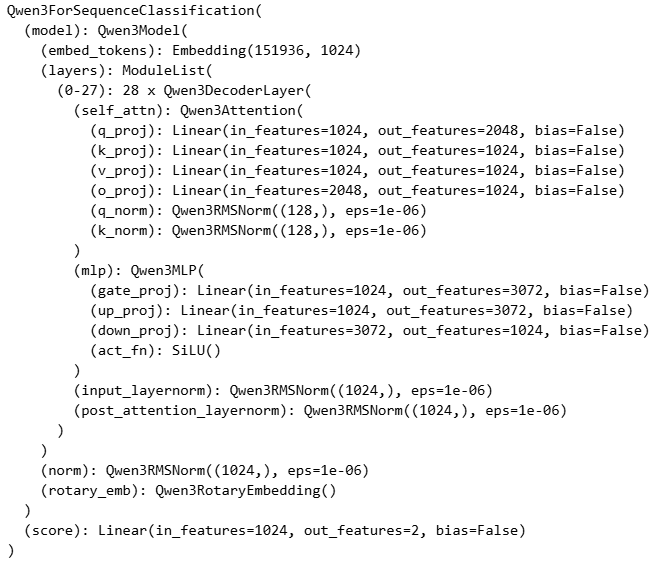

In [113]:
# 加入一个二分类的输出头，命名为classifier
model.classifier = torch.nn.Linear(model.config.hidden_size, 2) 
print(model)

Qwen3Model(
  (embed_tokens): Embedding(151936, 1024)
  (layers): ModuleList(
    (0-27): 28 x Qwen3DecoderLayer(
      (self_attn): Qwen3Attention(
        (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
        (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
        (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
      )
      (mlp): Qwen3MLP(
        (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
      (post_attention_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
    )
  )
  (norm): Qwen3RMSNorm((102

LoRA层的实现

返回经过LoRA层处理后的结果，并不是最终输出（还需要与原始线性层输出相加）

In [114]:
"""
需要定义两个可训练矩阵：A （in_dim x r）初始化为正态分布;  B（r x out_dim） 初始化为0
以及参数 rank 和 alpha
"""
import math
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, r, alpha):
        super(LoRALayer, self).__init__()
        self.r = r
        self.alpha = alpha
        self.A = torch.nn.Parameter(torch.empty(in_dim,r)) # 创建一个为0的A矩阵
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5)) # 用Kaiming初始化A矩阵（正态分布）
        self.B = torch.nn.Parameter(torch.zeros(r,out_dim)) # 创建一个为0的B矩阵
    
    def forward(self, x):
        # 这里的公式是：X*A*B*(alpha/r)
        x = (x @ self.A @ self.B) * (self.alpha / self.r)
        return x  

接下去要实现LoRA与原始线性层的相加

并不是定义一个新的nn.Linear，而是把LoRA层的结果和线性层结果组合在一起

In [115]:
class LoRAwithLinear(torch.nn.Module):
    def __init__(self, linear, r, alpha):
        super(LoRAwithLinear, self).__init__()
        # 原始的线性层
        self.linear = linear 
        # LoRA层, 为了能拼接，LoRA的维度要跟linear的维度一样
        self.lora = LoRALayer(linear.in_features, linear.out_features, r, alpha)  
    
    def forward(self, x):

        return self.linear(x) + self.lora(x)

In [116]:
def replace_with_LoRA(model,rank,alpha):
    for name, module in model.named_children():
        # isinstance(object, classinfo) 判断object是否是classinfo类的实例
        if isinstance(module, torch.nn.Linear):
            # setattr(object, name, value)，为对象object里的name属性设置value值
            setattr(model, name, LoRAwithLinear(module, rank, alpha))
        else:
            replace_with_LoRA(module, rank, alpha)